In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import entropy


In [2]:
plt.rcParams["figure.subplot.left"] = 0.22
plt.rcParams["figure.subplot.right"] = 0.95
plt.rcParams["figure.subplot.bottom"] = 0.20
plt.rcParams["figure.subplot.top"] = 0.95
plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['font.size'] = 22
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.handlelength'] = 1.5

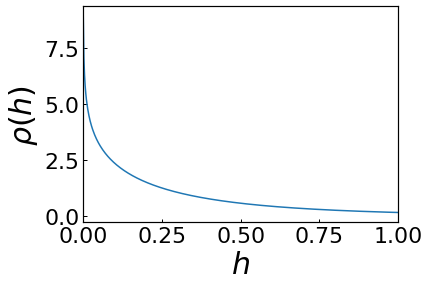

In [3]:
h = np.linspace(0.0, 1.0, num=501)[1::] # exclude the first because it can diverge
h = h - (h[1]-h[0])/2
kappa = np.arange(1,300)

def _rho(h, alpha=0.8, x_0=0.3):
    # Weibull distribution
    ro = alpha/x_0*(h/x_0)**(alpha-1) * np.exp( -(h/x_0)**alpha )
    dh = h[1]-h[0]
    return ro / (np.sum(ro)*dh)   # normalize to reduce numerical error

rho = _rho(h)
plt.xlim(0.0,1.0)
plt.xlabel(r"$h$")
plt.ylabel(r"$\rho(h)$")
plt.plot(h, rho)

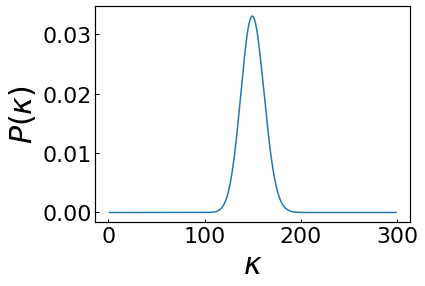

In [4]:
def _p_kappa(kappa):
    # delta function
    #return np.where(kappa == 150, 1, 0)
    # binomial distribution
    _n = 5000
    _p = 0.03
    b = binom(_n, _p)
    pmf = b.pmf(kappa)
    return pmf / np.sum(pmf)   # normalize to reduce error

P_kappa = _p_kappa(kappa)
plt.xlabel(r"$\kappa$")
plt.ylabel(r"$P(\kappa)$")
plt.plot(kappa,P_kappa)

In [5]:
def gen_mean(x,y,beta):  # when beta<=-10 or >=10, minimum or maximum is used
    if beta == 0:
        return np.sqrt(x*y)
    elif beta <= -10:
        return np.minimum(x,y)
    elif beta >= 10:
        return np.maximum(x,y)
    else:
        return ((x**beta+y**beta)/2)**(1.0/beta)

r = lambda x, y: gen_mean(x,y,-10)

r(1.0,3.0)

1.0

0.12005662658949999


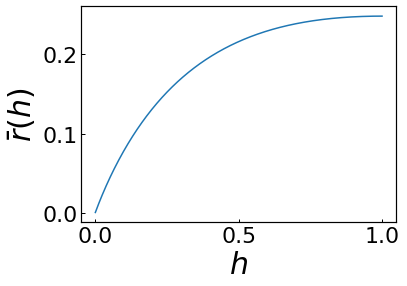

In [6]:
class NodalSampling:
    
    def __init__(self, h, kappa, rho_h, P_kappa, r):
        self.h = h
        self.nh = h.shape[0]
        self.dh = self.h[1]-self.h[0]
        self.kappa = kappa
        self.nkappa = kappa.shape[0]
        self.rho_h = rho_h
        assert( rho_h.shape == h.shape )
        self.P_kappa = P_kappa
        assert( P_kappa.shape == kappa.shape )
        self.r = r
        self.k = np.arange(0, np.amax(self.kappa)+1)
        self.nk = self.k.shape[0]
        self.results = {
            "r_bar_h": None,
            "r_bar": None,
            "g": None,
            "P_k": None,
            "r_nn_h": None,
            "p_hprime_given_h": None,
            "c_h": None,
            "g_star": None
        }
        
    def r_bar_h(self):
        # sum_{h'} rho(h') r(h,h')
        if self.results["r_bar_h"] is not None:
            return self.results["r_bar_h"]
        h_prime = np.copy(self.h).reshape([1,self.nh])
        h_ = self.h.reshape( [self.nh,1] )
        rhh = self.r(h_, h_prime)
        dr = rhh*rho.reshape([1,self.nh])*self.dh
        self.results["r_bar_h"] = np.sum(dr,axis=1)
        return self.results["r_bar_h"]
    
    def r_bar(self):
        # sum_{h,h'} rho(h') rho(h) r(h,h')
        if self.results["r_bar"] is not None:
            return self.results["r_bar"]
        y = self.r_bar_h() * self.rho_h * self.dh
        self.results["r_bar"] = np.sum(y)
        return self.results["r_bar"]
    
    def g(self):
        # g(k|h,kappa) = \binom(kappa, k) r(h)^k ( 1-r(h))^{kappa-k}
        #   k,h,kappa are 0th,1st,2nd axis, respectively
        if self.results["g"] is not None:
            return self.results["g"]
        _p = self.r_bar_h().reshape([1,self.nh,1])
        _kappa = self.kappa.reshape([1,1,self.nkappa])
        b = binom(_kappa, _p)
        _k = self.k.reshape([self.nk,1,1])
        self.results["g"] = b.pmf(_k)
        return self.results["g"]
    
    def P_k(self):
        if self.results["P_k"] is not None:
            return self.results["P_k"]
        _g = self.g() * self.rho_h.reshape([1,self.nh,1]) * self.P_kappa.reshape([1,1,self.nkappa])
        self.results["P_k"] = np.sum(_g, axis=(1,2)) * self.dh
        return self.results["P_k"]
    
    def r_nn_h(self):
        # h, h_prime are axis=0,1, respectively.
        if self.results["r_nn_h"] is not None:
            return self.results["r_nn_h"]
        r_bar_h_prime = self.r_bar_h().reshape([1,self.nh])
        p_hprime_given_h = self._p_hprime_given_h()
        x = p_hprime_given_h * r_bar_h_prime
        self.results["r_nn_h"] = np.sum( x, axis=1 ) * self.dh
        return self.results["r_nn_h"]
    
    def k_nn_k(self, kappa_nn):
        # k, h, kappa are axis=0,1,2, respectively
        assert( kappa_nn.shape == self.kappa.shape )
        r_nn_h_ = self.r_nn_h().reshape( [1,self.nh,1] )
        kappa_nn_ = kappa_nn.reshape( [1,1,self.nkappa] )
        return 1 + np.sum( self.g_star() * r_nn_h_ * (kappa_nn_-1), axis=(1,2) ) * self.dh;
    
    def _p_hprime_given_h(self):
        # h,h' are axis-0,1
        # p(h'|h) = r(h',h) rho(h') / r_bar(h)
        if self.results["p_hprime_given_h"] is not None:
            return self.results["p_hprime_given_h"]
        h_ = self.h.reshape( (self.nh,1) )
        h_prime = self.h.reshape( (1,self.nh) )
        rho_hprime = self.rho_h.reshape( (1,self.nh) )
        rbar_h = self.r_bar_h().reshape( (self.nh,1) )
        self.results["p_hprime_given_h"] = r(h_, h_prime) * rho_hprime / rbar_h
        return self.results["p_hprime_given_h"]
    
    def c_h(self):
        # h, h', h'' are axis-0,1,2, respectively
        # \sum_{h', h''} = r(h', h'') * p(h'|h) * p(h''|h)
        if self.results["c_h"] is not None:
            return self.results["c_h"]
        nh = self.nh
        h_ = self.h.reshape( (nh,1,1) )
        h_prime = self.h.reshape( (1,nh,1) )
        h_prime2 = self.h.reshape( (1,1,nh) )
        p_hprime_given_h_ = self._p_hprime_given_h().reshape( (nh,nh,1) )
        p_hprime2_given_h_ = self._p_hprime_given_h().reshape( (nh,1,nh) )
        r_ = self.r(h_prime, h_prime2).reshape( (1,nh,nh) )
        self.results["c_h"] = np.sum( r_ * p_hprime_given_h_ * p_hprime2_given_h_, axis=(1,2) ) * self.dh * self.dh
        return self.results["c_h"]
    
    def c_k(self, c_o_kappa):
        # k, h, kappa are axis-0,1,2, respectively
        # 1/P(k) * \sum_{h,\kappa} g(k|h,\kappa) rho(h) P(\kappa) c_h c_o(\kappa)
        _c_o_kappa = c_o_kappa.reshape( (1,1,self.nkappa) )
        _rho_h = self.rho_h.reshape( (1,self.nh,1) )
        _p_kappa = self.P_kappa.reshape( (1,1,self.nkappa) )
        _c_h = self.c_h().reshape( (1,self.nh,1) )
        return 1.0 / self.P_k() * np.sum( self.g() * _rho_h * _p_kappa * _c_h * _c_o_kappa, axis=(1,2) ) * self.dh

    def g_star(self):
        # g*(h,kappa|k) = g(k|h,kappa)rho(h)P_o(kappa) / P(k)
        if self.results["g_star"] is not None:
            return self.results["g_star"]
        Pk = self.P_k()
        Pk_ = Pk[ Pk > 0 ]
        Pk_ = Pk_.reshape( [Pk_.shape[0],1,1,] )
        _g = self.g()[Pk > 0,:,:]
        rho_h_ = self.rho_h.reshape( [1,self.nh,1] )
        p_kappa_ = self.P_kappa.reshape( [1,1,self.nkappa] )
        self.results["g_star"] = _g / Pk_ * rho_h_ * p_kappa_
        return self.results["g_star"]

        
sampling = NodalSampling(h=h, kappa=kappa, rho_h=rho, P_kappa=P_kappa, r=r)
plt.xlabel(r"$h$")
plt.ylabel(r"$\bar{r}(h)$")
plt.plot(h, sampling.r_bar_h())
print(sampling.r_bar())

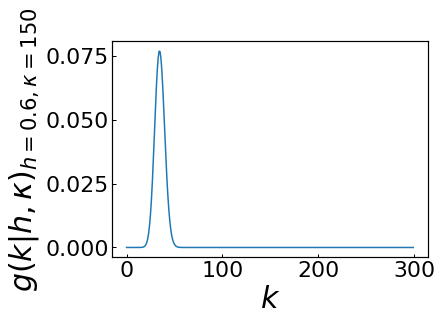

In [7]:
plt.xlabel(r"$k$")
plt.ylabel(r"$g(k|h,\kappa)_{h=0.6,\kappa=150}$")
plt.plot(sampling.k, sampling.g()[:,300,150])

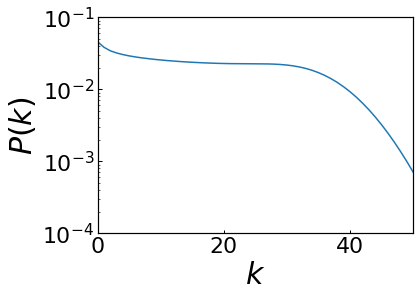

In [8]:
plt.yscale("log")
plt.ylim(1.0e-4,1.0e-1)
plt.xlim(0,50)
plt.xlabel(r"$k$")
plt.ylabel(r"$P(k)$")
plt.plot( sampling.k, sampling.P_k() )

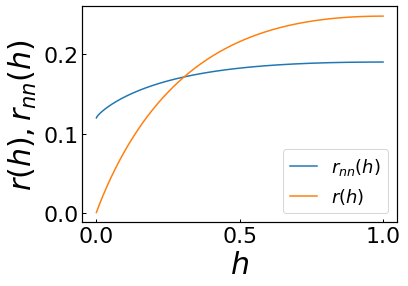

In [9]:
plt.xlabel(r"$h$")
plt.ylabel(r"$r(h), r_{nn}(h)$")
plt.plot(h, sampling.r_nn_h(), label=r"$r_{nn}(h)$")
plt.plot(h, sampling.r_bar_h(), label=r"$r(h)$")
plt.legend()

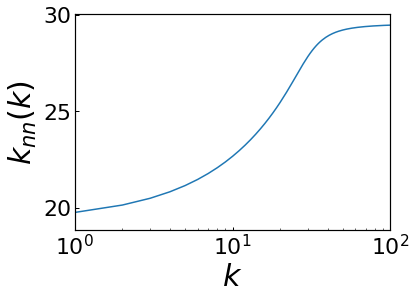

In [10]:
kappa_mean = np.sum(kappa * P_kappa)
kappa_nn = np.full(kappa.shape, kappa_mean + 1)
k_nn = sampling.k_nn_k(kappa_nn)
plt.xscale("log")
plt.xlabel(r"$k$")
plt.ylabel(r"$k_{nn}(k)$")
plt.xlim(1.0e0, 1.0e2)
plt.plot(sampling.k, k_nn)

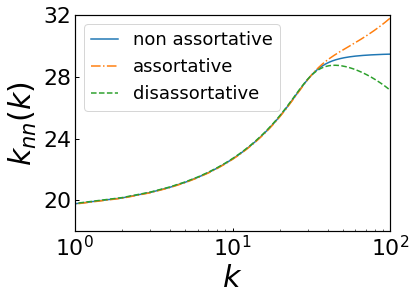

In [11]:
kappa_mean = np.sum(kappa * P_kappa)
kappa_nn = np.full(kappa.shape, kappa_mean + 1)
k_nn = sampling.k_nn_k(kappa_nn)
plt.xscale("log")
plt.xlim(1.0e0, 1.0e2)
plt.ylim(18,32)
plt.yticks( np.arange(20,33,step=4) )
plt.xlabel(r"$k$")
plt.ylabel(r"$k_{nn}(k)$")
plt.plot(sampling.k, k_nn, '-', label="non assortative")

kappa_nn = np.full(kappa.shape, kappa_mean + 1 + kappa*0.2-30)
#plt.plot(kappa, kappa_nn)
k_nn = sampling.k_nn_k(kappa_nn)
plt.plot(sampling.k, k_nn, '-.', label="assortative")

savefig = False

kappa_nn = np.full(kappa.shape, kappa_mean + 1 - kappa*0.2+30)
#plt.plot(kappa, kappa_nn)
k_nn = sampling.k_nn_k(kappa_nn)
plt.plot(sampling.k, k_nn, '--', label="disassortative")
plt.legend(loc="upper left")
if savefig:
    plt.savefig("knn_experiment.pdf")

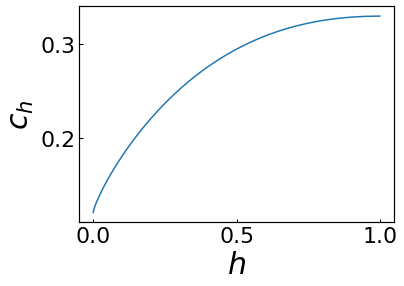

In [12]:
plt.xlabel(r"$h$")
plt.ylabel(r"$c_{h}$")
plt.plot(sampling.h, sampling.c_h())

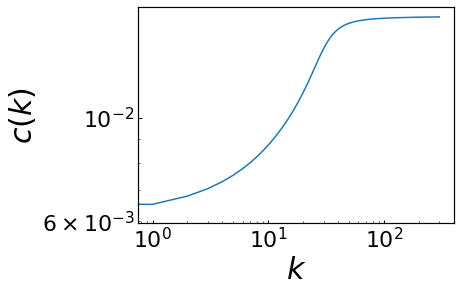

In [13]:
c_o_kappa = np.full( kappa.shape, 0.05 )
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$k$")
plt.ylabel(r"$c(k)$")
plt.plot(sampling.k, sampling.c_k(c_o_kappa))

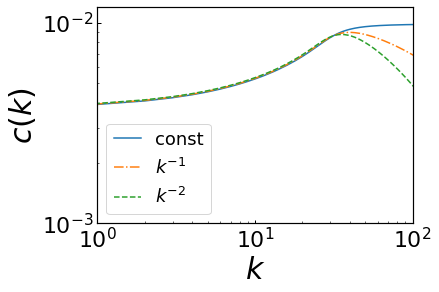

In [14]:
c_o = 0.03 # fix the original clustering coefficient
c_o_kappa = np.full(kappa.shape, c_o)
plt.xscale("log")
plt.yscale("log")
plt.xlim(1.0e0, 1.0e2)
plt.ylim(1.0e-3,1.2e-2)
plt.yticks([0.001,0.01])
plt.xlabel(r'$k$')
plt.ylabel(r'$c(k)$')
plt.plot(sampling.k, sampling.c_k(c_o_kappa), '-', label="const")

c_o_kappa = 1.0 / kappa
c_o_kappa = c_o_kappa / np.sum(c_o_kappa * P_kappa) * 0.03
plt.plot(sampling.k, sampling.c_k(c_o_kappa), '-.', label=r"$k^{-1}$")
plt.legend(loc="best")

c_o_kappa = 1.0 / (kappa**2)
c_o_kappa = c_o_kappa / np.sum(c_o_kappa * P_kappa) * 0.03
plt.plot(sampling.k, sampling.c_k(c_o_kappa), '--', label=r"$k^{-2}$")
plt.legend(loc="lower left")
if savefig:
    plt.savefig("ck_experiment.pdf")

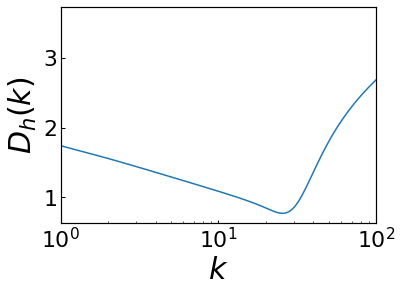

In [15]:
g_star_k_h = np.sum(sampling.g_star(), axis=2)
#plt.plot(h, g_star_k_h[10,:])
#plt.plot(h, rho)
kls = [entropy( g_star_k_h[k,:], rho ) for k in range( g_star_k_h.shape[0] )]
plt.xscale("log")
plt.xlim(1.0e0, 1.0e2)
plt.xlabel(r"$k$")
plt.ylabel(r"$D_{h}(k)$")
plt.plot(sampling.k, kls)

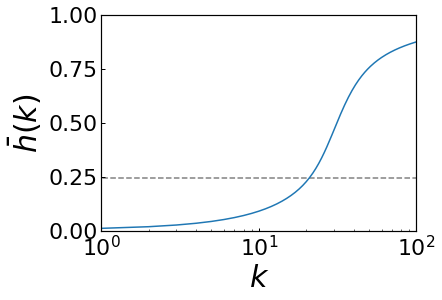

In [16]:
h_mean = np.sum(h * rho) * (h[1]-h[0])
hbar_k = np.sum( g_star_k_h * h.reshape([1,h.shape[0]]), axis=1 ) * (h[1]-h[0])
plt.xscale("log")
plt.xlim(1.0e0, 1.0e2)
plt.ylim(0.0, 1.0)
plt.xlabel(r"$k$")
plt.ylabel(r"$\bar{h}(k)$")
plt.plot(sampling.k, hbar_k)
plt.plot(sampling.k, np.full(sampling.k.shape, h_mean), '--', color='gray', zorder=1 )
if savefig:
    plt.savefig("hbar_k.pdf")

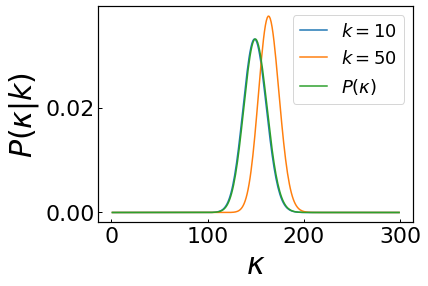

In [17]:
g_star_k_kappa = np.sum(sampling.g_star(), axis=1) * (h[1]-h[0])
plt.xlabel(r"$\kappa$")
plt.ylabel(r"$P(\kappa|k)$")
plt.plot(kappa, g_star_k_kappa[10,:], label=r"$k = 10$")
plt.plot(kappa, g_star_k_kappa[50,:], label=r"$k = 50$")
plt.plot(kappa, P_kappa, label =r"$P(\kappa)$")
plt.legend()

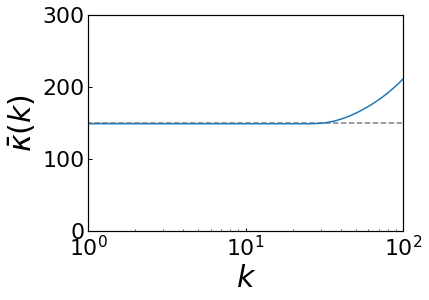

In [18]:
kappa_bar_k = np.sum( g_star_k_kappa * kappa.reshape([1,kappa.shape[0]]), axis=1 )
plt.xscale("log")
plt.xlim(1.0e0, 1.0e2)
plt.ylim(0,300)
plt.xlabel(r"$k$")
plt.ylabel(r"$\bar{\kappa}(k)$")
plt.yticks( np.arange(0,301,step=100) )
plt.plot( sampling.k, kappa_bar_k )
plt.plot( sampling.k, np.full( sampling.k.shape, kappa_mean), '--', color='gray', zorder=1 )
if savefig:
    plt.savefig("kappabar_k.pdf")

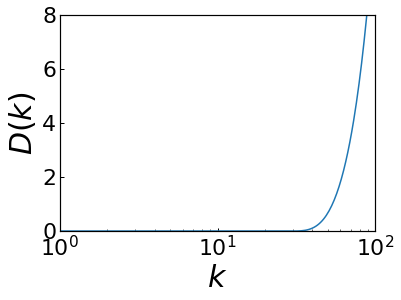

In [19]:
#kls = [entropy( P_kappa, g_star_k_kappa[k,:] ) for k in range( g_star_k_h.shape[0] )]
kls = [entropy( g_star_k_kappa[k,:], P_kappa ) for k in range( g_star_k_h.shape[0] )]
plt.xscale("log")
plt.xlabel(r"$k$")
plt.ylabel(r"$D(k)$")
plt.xlim(1.0e0, 1.0e2)
plt.ylim(0,8)
plt.plot(sampling.k, kls)
if savefig:
    plt.savefig("kl_divergence.pdf")